### Setup Environment:

In [1]:
from src.embeddings import load_data, split_dataset, train_and_evaluate_model

# Class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import os

# Models
# Random forest
from sklearn.ensemble import RandomForestClassifier
# Logistic regression
from sklearn.linear_model import LogisticRegression
# MLP
from sklearn.neural_network import MLPClassifier
# Support vector machine
from sklearn.svm import SVC
# Decision tree
#from sklearn.tree import DecisionTreeClassifier

2024-02-22 18:27:37.324781: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 18:27:37.369481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 18:27:37.369522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 18:27:37.370877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 18:27:37.378571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

## Evaluate the Embeddings

In [2]:
def run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, NORMAL=False, DR_ICDR_3=False, quality=False, oversample=False):
    
    # Get the dataset
    if quality:
        X_quality, y_quality, X_bad_quality, y_bad_quality = load_data(labels_path=LABELS_PATH, backbone=EMBEDDINGS_BACKBONE, label=LABEL, directory=EMBEDDINGS_DIR, normal=NORMAL, DR_ICDR_3=DR_ICDR_3, quality=quality)
    else:    
        X, y = load_data(labels_path=LABELS_PATH, backbone=EMBEDDINGS_BACKBONE, label=LABEL, directory=EMBEDDINGS_DIR, normal=NORMAL, DR_ICDR_3=DR_ICDR_3, quality=quality)

    if quality:
        X_train_quality, X_test_quality, y_train_quality, y_test_quality = split_dataset(X_quality, y_quality, test_size=TEST_SIZE, oversample=oversample)
        X_train_bad_quality, X_test_bad_quality, y_train_bad_quality, y_test_bad_quality = split_dataset(X_bad_quality, y_bad_quality, test_size=TEST_SIZE, oversample=oversample)

        X_train = np.concatenate((X_train_quality, X_train_bad_quality))
        y_train = np.concatenate((y_train_quality, y_train_bad_quality))
        
    else:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=TEST_SIZE, oversample=oversample)
    
    if quality:
        # Train and evaluate with good and bad quality subsets
        print('#'*50, ' GOOD QUALITY ', '#'*50)
        # Define a list of models to test
        if CLASS_WEIGTHS:
            class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
            # Create a dictionary from class labels and weights
            class_weights = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
            print(f'Setting class weigths to: {class_weights}')

            models = [
                #("SVM", SVC(class_weight=class_weights, probability=True)),
                ('Decision Tree', RandomForestClassifier(class_weight=class_weights)),
                #('Decision Tree', DecisionTreeClassifier(class_weight=class_weights)),
            ]
        else:
            models = [
                #("SVM", SVC(probability=True)),
                ('Decision Tree', RandomForestClassifier()),
                #('Decision Tree', DecisionTreeClassifier()),
            ]
        # Run the experiments
        print('#'*50, ' Train all evaluate good quality ', '#'*50)
        model, wrong_indices_good = train_and_evaluate_model(X_train, X_test_quality, y_train, y_test_quality, models=models)
        
        print('#'*50, ' Train all evaluate bad quality ', '#'*50)
        model, wrong_indices_bad = train_and_evaluate_model(X_train, X_test_bad_quality, y_train, y_test_bad_quality, models=models)
        
        return wrong_indices_good, wrong_indices_bad
        
    else:
        # Define a list of models to test
        if CLASS_WEIGTHS:
            class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
            # Create a dictionary from class labels and weights
            class_weights = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
            print(f'Setting class weigths to: {class_weights}')

            models = [
                #("SVM", SVC(class_weight=class_weights, probability=True)),
                #("Logistic Regression", LogisticRegression(class_weight=class_weights)),
                ('Decision Tree', RandomForestClassifier(class_weight=class_weights)),
                #("MLP Classifier", MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam')),
            ]
        else:
            models = [
                #("SVM", SVC(probability=True)),
                #("Logistic Regression", LogisticRegression())
                ('Decision Tree', RandomForestClassifier()),
                #("MLP Classifier", MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam')),
            ]

        # Run the experiments
        model, wrong_indices = train_and_evaluate_model(X_train, X_test, y_train, y_test, models=models)
        
        return wrong_indices

#### Constants

In [3]:

# Constants:
LABELS_PATH = '/home/opc/Retina/BRSET/labels.csv'
EMBEDDINGS_BACKBONE = None
EMBEDDINGS_DIR = 'Embeddings'
TEST_SIZE = 0.3
CLASS_WEIGTHS = True
quality = False
oversample=True

### Sex Prediction

Training set size is: 11386 rows and 1024 columns
Test set size is: 4880 rows and 1024 columns
Applied SMOTE to oversample the training set.


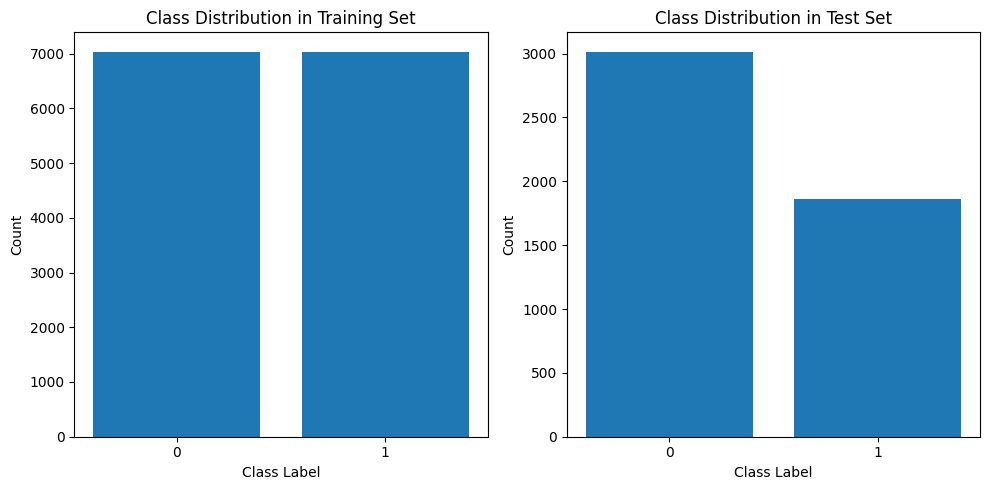

Setting class weigths to: {0: 1.0, 1: 1.0}


####################  Decision Tree  ####################


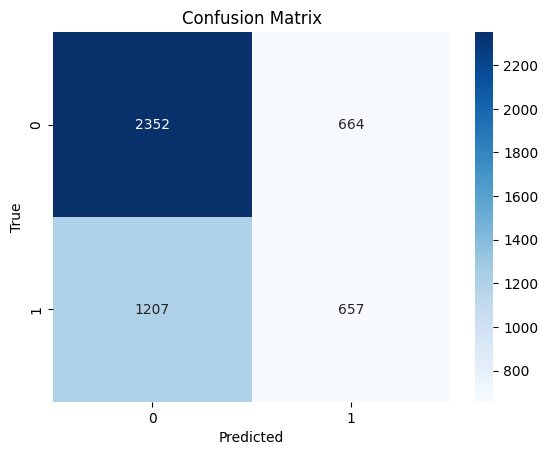

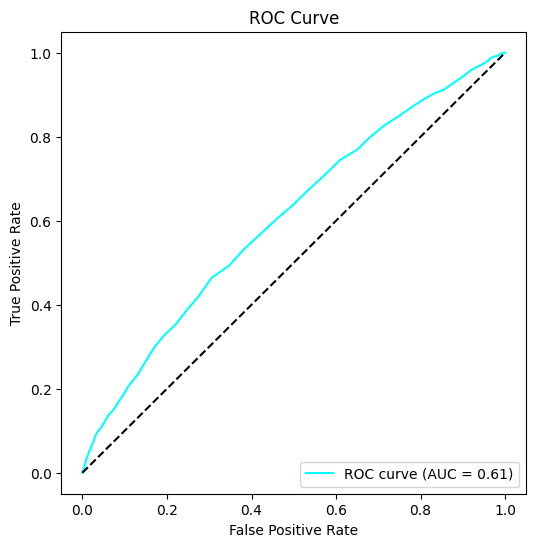

              precision    recall  f1-score   support

           0       0.66      0.78      0.72      3016
           1       0.50      0.35      0.41      1864

    accuracy                           0.62      4880
   macro avg       0.58      0.57      0.56      4880
weighted avg       0.60      0.62      0.60      4880



In [4]:
LABEL = 'patient_sex'

if quality:
    wrong_indices_good, wrong_indices_bad = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, quality=quality, oversample=oversample)
else:
    wrong_indices = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, quality=quality, oversample=oversample)

## Diabetic Retinopathy

### 5 Class

Training set size is: 11386 rows and 1024 columns
Test set size is: 4880 rows and 1024 columns
Applied SMOTE to oversample the training set.


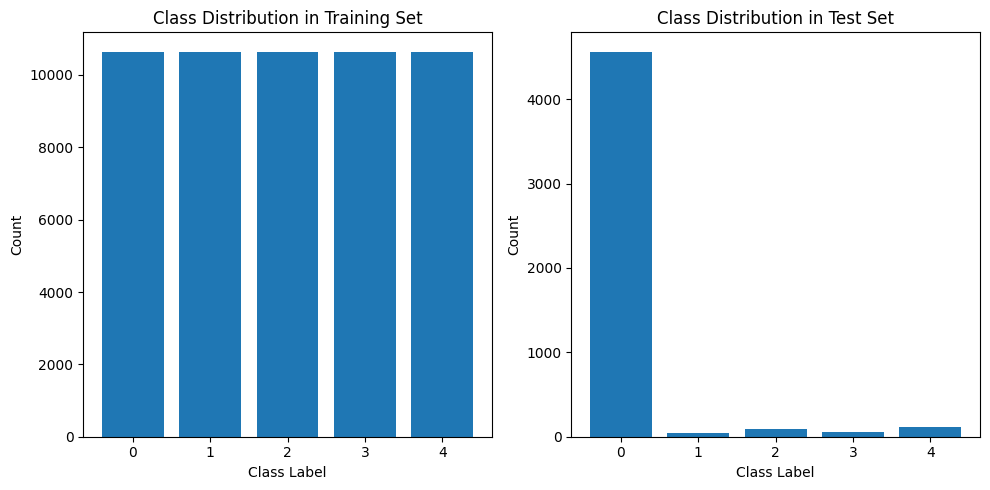

Setting class weigths to: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


####################  Decision Tree  ####################


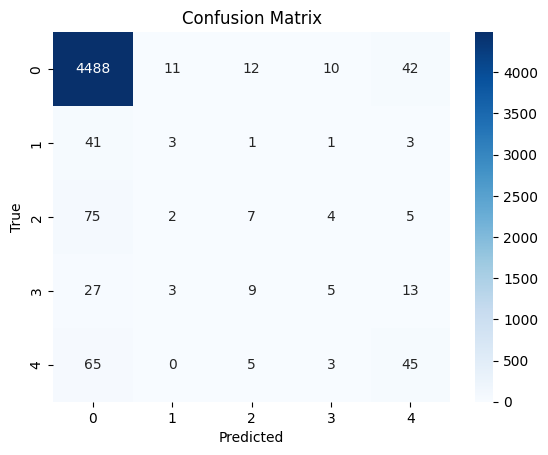

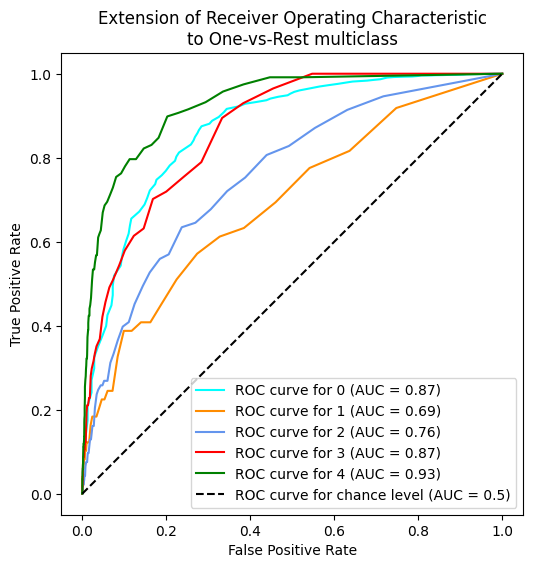

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4563
           1       0.16      0.06      0.09        49
           2       0.21      0.08      0.11        93
           3       0.22      0.09      0.12        57
           4       0.42      0.38      0.40       118

    accuracy                           0.93      4880
   macro avg       0.39      0.32      0.34      4880
weighted avg       0.91      0.93      0.92      4880



In [5]:
LABEL = 'DR_ICDR'
DR_ICDR_3 = False

if quality:
    wrong_indices_good, wrong_indices_bad = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, DR_ICDR_3=DR_ICDR_3, quality=quality, oversample=oversample)
else:
    wrong_indices = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, DR_ICDR_3=DR_ICDR_3, quality=quality, oversample=oversample)
    

### 3 Class

Training set size is: 11386 rows and 1024 columns
Test set size is: 4880 rows and 1024 columns
Applied SMOTE to oversample the training set.


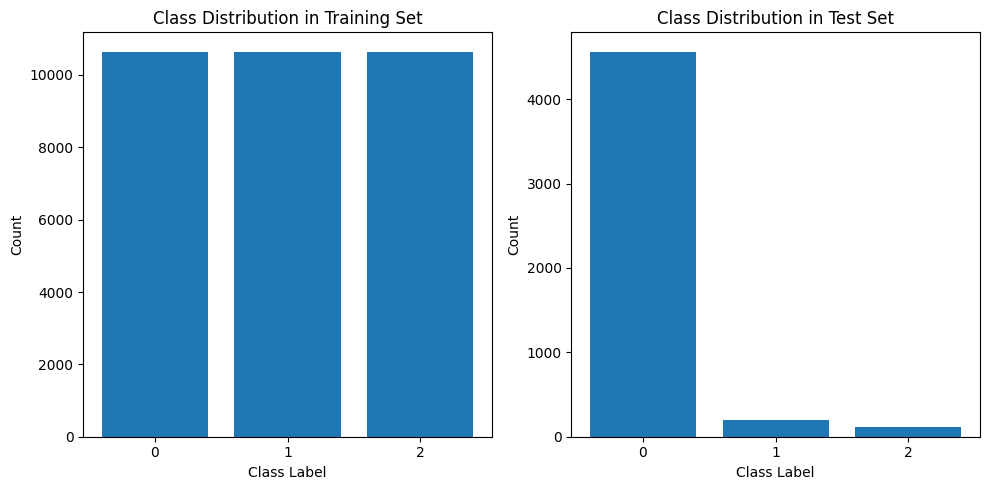

Setting class weigths to: {0: 1.0, 1: 1.0, 2: 1.0}


####################  Decision Tree  ####################


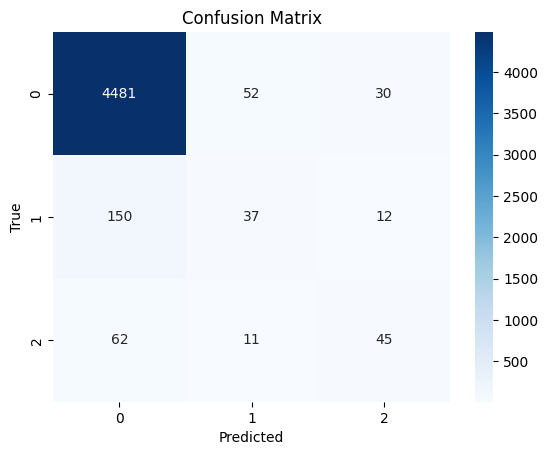

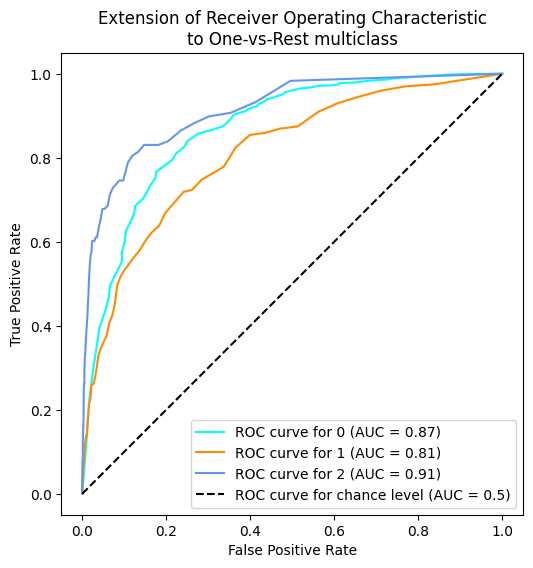

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4563
           1       0.37      0.19      0.25       199
           2       0.52      0.38      0.44       118

    accuracy                           0.94      4880
   macro avg       0.61      0.52      0.55      4880
weighted avg       0.92      0.94      0.93      4880



In [6]:
LABEL = 'DR_ICDR'
DR_ICDR_3= True
if quality:
    wrong_indices_good, wrong_indices_bad = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, DR_ICDR_3=DR_ICDR_3, quality=quality, oversample=oversample)
else:
    wrong_indices = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, DR_ICDR_3=DR_ICDR_3, quality=quality, oversample=oversample)

### 2 Class

Training set size is: 11386 rows and 1024 columns
Test set size is: 4880 rows and 1024 columns
Applied SMOTE to oversample the training set.


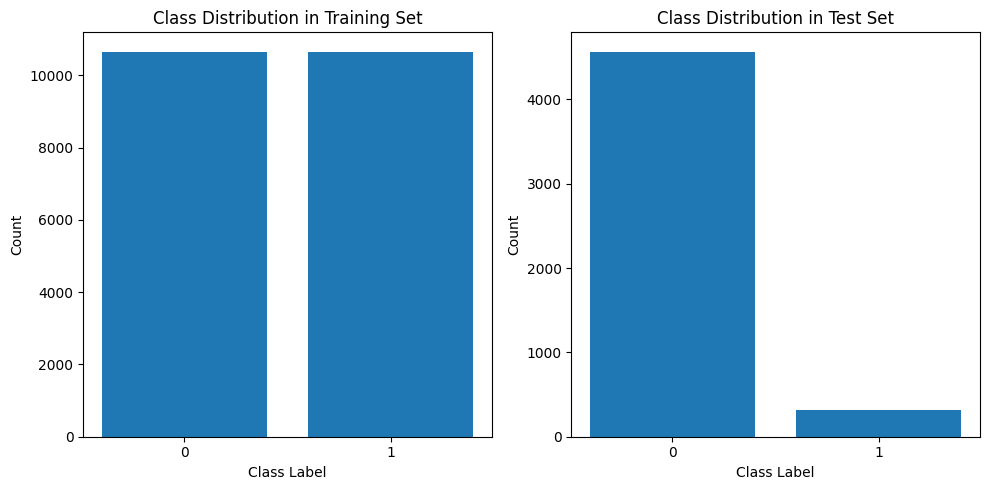

Setting class weigths to: {0: 1.0, 1: 1.0}


####################  Decision Tree  ####################


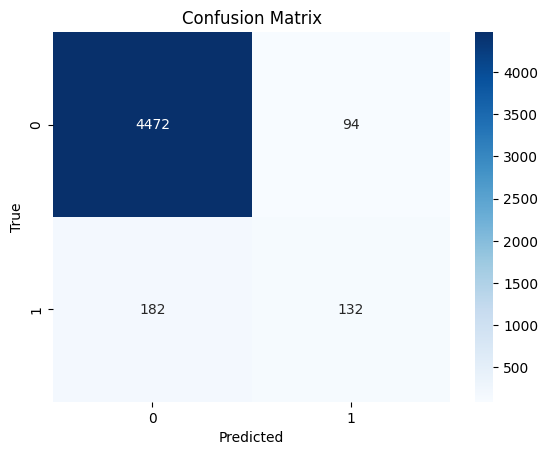

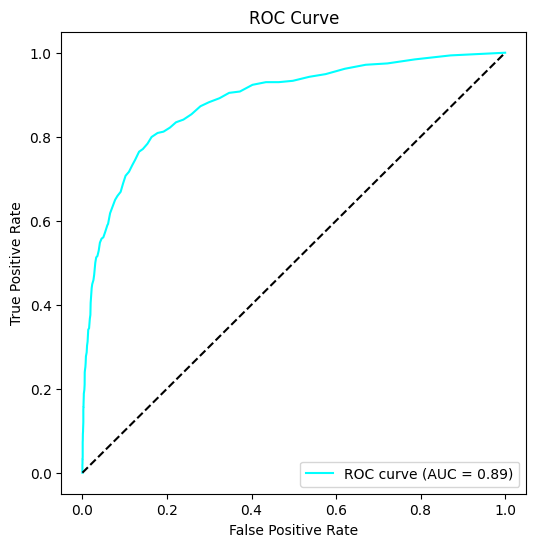

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4566
           1       0.58      0.42      0.49       314

    accuracy                           0.94      4880
   macro avg       0.77      0.70      0.73      4880
weighted avg       0.94      0.94      0.94      4880



In [7]:
LABEL = 'diabetic_retinopathy'
if quality:
    wrong_indices_good, wrong_indices_bad = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, quality=quality, oversample=oversample)
else:
    wrong_indices = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, quality=quality, oversample=oversample)